# Basic circuit creation and visualization


## Circuit creation

In [1]:
from pytket.circuit import Circuit, OpType

In [2]:
c = Circuit(4, name="example")
c.add_gate(OpType.CU1, 0.5, [0, 1])
c.H(0).X(1).Y(2).Z(3)
c.X(0).CX(1, 2).Y(1).Z(2).H(3)
c.Y(0).Z(1)
c.add_gate(OpType.CU1, 0.5, [2, 3])
c.H(2).X(3)
c.Z(0).H(1).X(2).Y(3).CX(3, 0)

[CU1(0.5) q[0], q[1]; Y q[2]; Z q[3]; H q[0]; X q[1]; H q[3]; X q[0]; CX q[1], q[2]; Y q[0]; Y q[1]; Z q[2]; Z q[0]; Z q[1]; CU1(0.5) q[2], q[3]; H q[1]; H q[2]; X q[3]; X q[2]; Y q[3]; CX q[3], q[0]; ]

Checking the number of qubits

In [3]:
c.n_qubits

4

And the depth of the circuit

In [4]:
c.depth()

8

We can also check the depth by type of gates

In [5]:
from pytket.circuit import OpType

In [6]:
c.depth_by_type(OpType.CU1), c.depth_by_type(OpType.H)

(2, 2)

## Circuit Visualization
There are multiple ways to visualize a circuit, using tket tools, but also leveraging tools from other frameworks.
### Circuit visualization using tket
There are few ways for do circuit visualization using tket.
We can view the circuit as a graph:

In [7]:
from pytket.utils import Graph


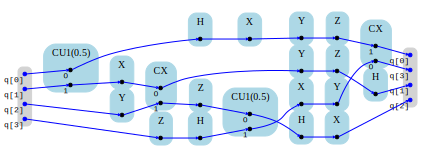

In [8]:
G = Graph(c)
G.get_DAG()


Or use the jupyter rendering:

In [9]:
from pytket.circuit.display import render_circuit_jupyter
render_circuit_jupyter(c)

Of course we can also generate the corresponding latex file and generate the associated pdf file (assuming a working installation of $LaTeX$)

In [22]:
c.to_latex_file("c.tex")
#!pdflatex c.tex
#!open c.pdf

### Circuit visualization usint the Qiskit viewer, basic and leveraging matplotlib

Converters for other quantum software frameworks can optionally be included by installing the corresponding extension module. These are additional PyPI packages with names pytket-X, which extend the pytket namespace with additional features to interact with other systems, either using them as a front-end for circuit construction and high-level algorithms or targeting simulators and devices as backends.

For example, installing the pytket-qiskit package will add the tk_to_qiskit and qiskit_to_tk methods which convert between the Circuit class from pytket and qiskit.QuantumCircuit


In [59]:
from pytket.extensions.qiskit import tk_to_qiskit, qiskit_to_tk

In [12]:
print(tk_to_qiskit(c))


               ┌───┐┌───┐┌───┐  ┌───┐             ┌───┐
q_0: ─■────────┤ H ├┤ X ├┤ Y ├──┤ Z ├─────────────┤ X ├
      │U1(π/2) ├───┤└───┘├───┤  ├───┤   ┌───┐     └─┬─┘
q_1: ─■────────┤ X ├──■──┤ Y ├──┤ Z ├───┤ H ├───────┼──
       ┌───┐   └───┘┌─┴─┐├───┤  └───┘   ├───┤┌───┐  │  
q_2: ──┤ Y ├────────┤ X ├┤ Z ├─■────────┤ H ├┤ X ├──┼──
       ├───┤   ┌───┐└───┘└───┘ │U1(π/2) ├───┤├───┤  │  
q_3: ──┤ Z ├───┤ H ├───────────■────────┤ X ├┤ Y ├──■──
       └───┘   └───┘                    └───┘└───┘     


Note that pylatexenc needs to be installed in order to leverage matplotlib for visualization (included when setting up the environment via yaml file)

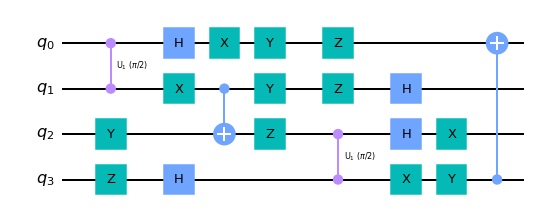

In [13]:
tk_to_qiskit(c).draw(output='mpl')

Finally, cirq can also be used

In [14]:
from pytket.extensions.cirq import tk_to_cirq


In [15]:
print(tk_to_cirq(c))


0: ───@───────H───X───Y───Z───────────────X───
      │                                   │
1: ───@^0.5───X───@───Y───Z───────H───────┼───
                  │                       │
2: ───Y───────────X───Z───@───────H───X───┼───
                          │               │
3: ───Z───────H───────────@^0.5───X───Y───@───


### circuit manipulation

In [61]:
from pytket import Circuit, Qubit, Bit
circ = Circuit(2, 2)
circ.CX(0, 1)
circ.Rz(0.3, 1)
circ.CX(0, 1)

render_circuit_jupyter(circ)

In [62]:
measures = Circuit(2, 2)
render_circuit_jupyter(measures)

In [63]:
measures.H(1)
render_circuit_jupyter(measures)

In [64]:
measures.measure_all()
render_circuit_jupyter(measures)

In [65]:
circ.append(measures)
render_circuit_jupyter(circ)

As usual, if you prefer to visualize the circuit using Qiskit, we are just one line of code away

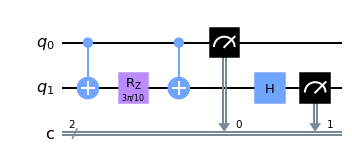

In [66]:
tk_to_qiskit(circ).draw(output='mpl')

# Quick note on Backends

Every device and simulator will have some restrictions to allow for a simpler implementation or because of the limits of engineering or noise within a device. For example, devices and simulators are typically designed to only support a small (but universal) gate set, so a Circuit containing other gate types could not be run immediately. However, as long as the fragment supported is universal, it is enough to be able to compile down to a semantically-equivalent Circuit which satisfies the requirements, for example, by translating each unknown gate into sequences of known gates.

Other common restrictions presented by QPUs include the number of available qubits and their connectivity (multi-qubit gates may only be performed between adjacent qubits on the architecture). Measurements may also be noisy or take a long time on some QPUs, leading to the destruction or decoherence of any remaining quantum state, so they are artificially restricted to only happen in a single layer at the end of execution and mid-circuit measurements are rejected. More extremely, some classes of classical simulators will reject measurements entirely as they are designed to simulate pure quantum circuits (for example, when looking to yield a statevector or unitary deterministically).

Each Backend object is aware of the restrictions of the underlying device or simulator, encoding them as a collection of Predicate s. Each Predicate is essentially a Boolean property of a Circuit which must return True for the Circuit to successfully run. The set of Predicates required by a Backend can be queried with Backend.required_predicates.


In [106]:
from pytket.extensions.qiskit import IBMQBackend, AerStateBackend
dev_b = IBMQBackend("ibmq_athens")
sim_b = AerStateBackend()
print(dev_b.required_predicates)
print(sim_b.required_predicates)

[NoSymbolsPredicate, GateSetPredicate:{ Rz CX U3 noop U2 Measure U1 Barrier X Reset SX }]
[NoClassicalControlPredicate, NoFastFeedforwardPredicate, GateSetPredicate:{ S CnX H Y Sdg Unitary2qBox Ry Rz Mølmer-Sørensen X ZZPhase YYPhase Z T Tdg SX Rx Unitary1qBox U3 U2 U1 CX CY CZ CU1 CU3 CCX SWAP CSWAP noop PhasedX }]


# Circuit compilation and optimization

The primary goals of compilation are two-fold: solving the constraints of the Backend to get from the abstract model to something runnable, and optimising/simplifying the Circuit to make it faster, smaller, and less prone to noise. Every step in compilation can generally be split up into one of these two categories (though even the constraint solving steps could have multiple solutions over which we could optimise for noise).

Each compiler pass inherits from the BasePass class, capturing a method of transforming a Circuit. The main functionality is built into the BasePass.apply() method, which applies the transformation to a Circuit in-place. The Backend.compile_circuit() method is simply an alias for BasePass.apply() from the Backend ‘s recommended pass sequence. 


### Rebases
One of the simplest constraints to solve for is the GateSetPredicate, since we can just substitute each gate in a Circuit with an equivalent sequence of gates in the target gateset according to some known gate decompositions. In pytket, such passes are referred to as “rebases”. The intention here is to perform this translation naively, leaving the optimisation of gate sequences to other passes. Rebases can be applied to any Circuit and will preserve every structural Predicate, only changing the types of gates used.



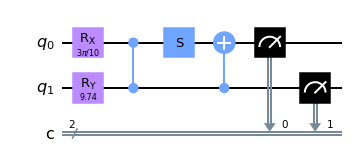

In [182]:
from pytket import Circuit
from pytket.passes import RebaseIBM
circ = Circuit(2, 2)
circ.Rx(0.3, 0).Ry(-0.9, 1).CZ(0, 1).S(0).CX(1, 0).measure_all()

tk_to_qiskit(circ).draw(output='mpl')



In [183]:
RebaseIBM().apply(circ)

print(circ.get_commands())


[U3(0.3, 1.5, 0.5) q[0];, U3(3.1, 0, 0) q[1];, U3(0.5, 0, 1) q[1];, CX q[0], q[1];, U1(0.5) q[0];, U3(0.5, 0, 1) q[1];, CX q[1], q[0];, Measure q[0] --> c[0];, Measure q[1] --> c[1];]


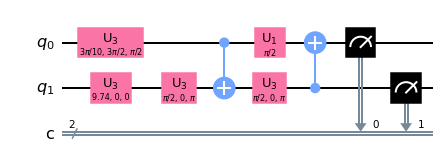

In [124]:
tk_to_qiskit(circ).draw(output='mpl')


### Placement

Now that we saw how to transform a circuit so it matches a specific target gateset (and it is easy to define a rebase for an arbitrary gateset), we can have a look into placement, and then routing.


Initially, a Circuit designed without a target device in mind will be expressed in terms of actions on a set of “logical qubits” - those with semantic meaning to the computation. A placement (or initial mapping) is a map from these logical qubits to the physical qubits of the device that will be used to carry them. A given placement may be preferred over another if the connectivity of the physical qubits better matches the interactions between the logical qubits caused by multi-qubit gates, or if the selection of physical qubits has better noise characteristics. All of the information for connectivity and noise characteristics of a given Backend is wrapped up in a Device object by the Backend.device property.

The placement only specifies where the logical qubits will be at the start of execution, which is not necessarily where they will end up on termination. Other compiler passes may choose to permute the qubits in the middle of a Circuit to either exploit further optimisations or enable interactions between logical qubits that were not assigned to adjacent physical qubits.

A placement pass will act in place on a Circuit by renaming the qubits from their logical names (the UnitID s used at circuit construction) to their physical addresses (the UnitID s recognised by the Backend). Classical data is never renamed.



In [207]:
from pytket import Circuit
from pytket.extensions.qiskit import IBMQBackend
from pytket.passes import PlacementPass
from pytket.predicates import ConnectivityPredicate
from pytket.routing import GraphPlacement, NoiseAwarePlacement
circ = Circuit(4, 4)
circ.H(0).H(1).H(2).V(3)
circ.CX(0, 1).CX(1, 2).CX(2, 3)
circ.Rz(-0.37, 3)
circ.CX(2, 3).CX(1, 2).CX(0, 1)
circ.H(0).H(1).H(2).Vdg(3)
circ.measure_all()


render_circuit_jupyter(circ)



<figure>
<img src="files/belem.png" width="200" height="100"
     alt="belem" >
<figcaption>IBM Belem device</figcaption>
</figure>


In [212]:
backend = IBMQBackend("ibmq_belem")
place = PlacementPass(GraphPlacement(backend.device))
#place = PlacementPass(NoiseAwarePlacement(backend.device))
place.apply(circ)

print(circ.get_commands())
print(ConnectivityPredicate(backend.device).verify(circ))

[V node[0];, H node[1];, H node[3];, H node[4];, CX node[4], node[3];, CX node[3], node[1];, CX node[1], node[0];, Rz(3.63) node[0];, CX node[1], node[0];, Vdg node[0];, CX node[3], node[1];, Measure node[0] --> c[3];, H node[1];, CX node[4], node[3];, Measure node[1] --> c[2];, H node[3];, H node[4];, Measure node[4] --> c[0];, Measure node[3] --> c[1];]
True


In [213]:
render_circuit_jupyter(circ)

Alternatively, we cal also use the NoiseAware placement and see the difference

In [216]:
backend = IBMQBackend("ibmq_belem")
place = PlacementPass(NoiseAwarePlacement(backend.device))
place.apply(circ)

print(circ.get_commands())
print(ConnectivityPredicate(backend.device).verify(circ))

[H node[1];, V node[2];, H node[3];, H node[4];, CX node[4], node[3];, CX node[3], node[1];, CX node[1], node[2];, Rz(3.63) node[2];, CX node[1], node[2];, CX node[3], node[1];, Vdg node[2];, Measure node[2] --> c[3];, H node[1];, CX node[4], node[3];, Measure node[1] --> c[2];, H node[3];, H node[4];, Measure node[4] --> c[0];, Measure node[3] --> c[1];]
True


In [217]:
render_circuit_jupyter(circ)

<figure>
<img src="files/athens.png" width="200" height="100"
     alt="athens" >
<figcaption>IBM Athens device</figcaption>
</figure>

In [140]:
backend = IBMQBackend("ibmq_athens")
place = PlacementPass(GraphPlacement(backend.device))
place.apply(circ)

print(circ.get_commands())
print(ConnectivityPredicate(backend.device).verify(circ))

[H node[0];, H node[1];, H node[2];, V node[3];, CX node[0], node[1];, CX node[1], node[2];, CX node[2], node[3];, Rz(3.63) node[3];, CX node[2], node[3];, CX node[1], node[2];, Vdg node[3];, Measure node[3] --> c[3];, CX node[0], node[1];, H node[2];, Measure node[2] --> c[2];, H node[0];, H node[1];, Measure node[0] --> c[0];, Measure node[1] --> c[1];]
True


In [141]:
render_circuit_jupyter(circ)

Several heuristics have been implemented for identifying candidate placements. For example, LinePlacement will try to identify long paths on the connectivity graph which could be treated as a linear nearest-neighbour system. GraphPlacement will try to identify a subgraph isomorphism between the graph of interacting logical qubits (up to some depth into the Circuit) and the connectivity graph of the physical qubits. Then NoiseAwarePlacement extends this to break ties in equivalently good graph maps by looking at the error rates of the physical qubits and their couplers. 

The latter two can be configured using e.g. GraphPlacement.modify_config() to change parameters like how far into the Circuit it will look for interacting qubits (trading off time spent searching for the chance to find a better placement).



### Routing
The heterogeneity of quantum architectures and limited connectivity of their qubits impose the strict restriction that multi-qubit gates are only allowed between specific pairs of qubits. Given it is far easier to program a high-level operation which is semantically correct and meaningful when assuming full connectivity, a compiler will have to solve this constraint. In general, there won’t be an exact subgraph isomorphism between the graph of interacting logical qubits and the connected physical qubits, so this cannot be solved with placement alone.

One solution here, is to scan through the Circuit looking for invalid interactions. Each of these can be solved by either moving the qubits around on the architecture by adding OpType.SWAP gates until they are in adjacent locations, or performing a distributed entangling operation using the intervening qubits (such as the “bridged-CX” OpType.BRIDGE which uses 4 CX gates and a single shared neighbour). The routing procedure in pytket takes a placed Circuit and inserts gates to reduce non-local operations to sequences of valid local ones.



In [150]:
from pytket import Circuit
from pytket.extensions.qiskit import IBMQBackend
from pytket.passes import PlacementPass, RoutingPass
from pytket.routing import GraphPlacement
circ = Circuit(4)
circ.CX(0, 1).CX(0, 2).CX(1, 2).CX(3, 2).CX(0, 3)


[CX q[0], q[1]; CX q[0], q[2]; CX q[1], q[2]; CX q[3], q[2]; CX q[0], q[3]; ]

In [151]:
render_circuit_jupyter(circ)

In [152]:
backend = IBMQBackend("ibmq_belem")
PlacementPass(GraphPlacement(backend.device)).apply(circ)
print(circ.get_commands())  # One qubit still unplaced
                            # node[0] and node[2] are not adjacent



[CX node[1], node[0];, CX node[1], node[2];, CX node[0], node[2];, CX unplaced[0], node[2];, CX node[1], unplaced[0];]


In [153]:
render_circuit_jupyter(circ)

In [154]:
RoutingPass(backend.device).apply(circ)
print(circ.get_commands())

[CX node[1], node[0];, CX node[1], node[2];, SWAP node[0], node[1];, CX node[1], node[2];, SWAP node[1], node[3];, CX node[1], node[2];, CX node[0], node[1];]


In [155]:
render_circuit_jupyter(circ)

We now have a circuit that can actually be executed on a specific device.

### Optimisations
Having covered the primary goal of compilation and reduced our Circuit s to a form where they can be run, we find that there are additional techniques we can use to obtain more reliable results by reducing the noise and probability of error. Most Circuit optimisations follow the mantra of “fewer expensive resources gives less opportunity for noise to creep in”, whereby if we find an alternative Circuit that is observationally equivalent in a perfect noiseless setting but uses fewer resources (gates, time, ancilla qubits) then it is likely to perform better in a noisy context (though not always guaranteed).

If we have two Circuits that are observationally equivalent, we know that replacing one for the other in any context also gives something that is observationally equivalent. The simplest optimisations will take an inefficient pattern, find all matches in the given Circuit and replace them by the efficient alternative. A good example from this class of peephole optimisations is the RemoveRedundancies pass, which looks for a number of easy-to-spot redundant gates, such as zero-parameter rotation gates, gate-inverse pairs, adjacent rotation gates in the same basis, and diagonal rotation gates followed by measurements.



In [160]:
from pytket import Circuit, OpType
from pytket.passes import RemoveRedundancies
circ = Circuit(3, 3)
circ.Rx(0.92, 0).CX(1, 2).Rx(-0.18, 0)  # Adjacent Rx gates can be merged
circ.CZ(0, 1).Ry(0.11, 2).CZ(0, 1)      # CZ is self-inverse
circ.add_gate(OpType.XXPhase, 0.6, [0, 1])
circ.add_gate(OpType.YYPhase, 0, [0, 1])    # 0-angle rotation does nothing
circ.add_gate(OpType.ZZPhase, -0.84, [0, 1])
circ.Rx(0.03, 0).Rz(-0.9, 1).measure_all()  # Effect of Rz is eliminated by measurement

print(circ.get_commands())

[Rx(0.92) q[0];, CX q[1], q[2];, Rx(3.82) q[0];, Ry(0.11) q[2];, Measure q[2] --> c[2];, CZ q[0], q[1];, CZ q[0], q[1];, Mølmer-Sørensen(0.6) q[0], q[1];, YYPhase(0) q[0], q[1];, ZZPhase(3.16) q[0], q[1];, Rx(0.03) q[0];, Rz(3.1) q[1];, Measure q[0] --> c[0];, Measure q[1] --> c[1];]


In [161]:
render_circuit_jupyter(circ)

In [162]:
RemoveRedundancies().apply(circ)
print(circ.get_commands())


[Rx(0.74) q[0];, CX q[1], q[2];, Mølmer-Sørensen(0.6) q[0], q[1];, Ry(0.11) q[2];, Measure q[2] --> c[2];, ZZPhase(3.16) q[0], q[1];, Measure q[1] --> c[1];, Rx(0.03) q[0];, Measure q[0] --> c[0];]


In [163]:
render_circuit_jupyter(circ)

A set of passes can be applied in order to fully optimize the circuit. This can be done manually byt pytket also has a default predefined sequences (i.e. levels of optimization.)
Level 0: Just solves the constraints as simply as possible. No optimisation.
Level 1: Adds basic optimisations for efficient compilation.
Level 2: Extends to more intensive optimisations.

In [164]:
from pytket import Circuit, OpType
from pytket.extensions.qiskit import AerBackend
circ = Circuit(3)
circ.CZ(0, 1)
circ.H(1)
circ.Rx(0.42, 1)
circ.S(1)
circ.add_gate(OpType.YYPhase, 0.96, [1, 2])
circ.CX(0, 1)
circ.measure_all()
b = AerBackend()
for ol in range(3):
    test = circ.copy()
    b.default_compilation_pass(ol).apply(test)
    assert b.valid_circuit(test)
    print("Optimisation level", ol)
    print("Gates", test.n_gates)
    print("CXs", test.n_gates_of_type(OpType.CX))


Optimisation level 0
Gates 9
CXs 1
Optimisation level 1
Gates 13
CXs 4
Optimisation level 2
Gates 12
CXs 3


In [16]:
from pytket.extensions.qiskit.tket_backend import TketBackend
from pytket.passes import RebaseIBM, SequencePass

In [17]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.extensions.qiskit import IBMQBackend

In [18]:
from pytket.extensions.qiskit import TketPass

ImportError: cannot import name 'TketPass' from 'pytket.extensions.qiskit' (/Users/mbozzore/opt/anaconda3/envs/tket_demo_1/lib/python3.9/site-packages/pytket/extensions/qiskit/__init__.py)

In [ ]:
seq = SequencePass([
    # Insert pytket pass of choice
    RebaseIBM(),
])

In [ ]:
backend = IBMQBackend("ibmq_santiago")
for key in backend.characterisation:
    print(key)

In [ ]:
c1 = Circuit(3)
c1.depth() 



In [ ]:
c1.CX(0,1)
c1.CX(1,2)
c1.CX(2,0)
c1.depth()

In [ ]:
render_circuit_jupyter(c1)

In [ ]:
measure_all(c1)

In [ ]:
c2 = Circuit(3)

c2.CX(0,1)
c2.Z(1)
c2.CX(1,2)

In [ ]:
render_circuit_jupyter(c2)

In [ ]:
c1.depth_by_type(OpType.CX)

### Embedding into Qiskit
Not only is the goal of tket to be a device-agnostic platform, but also interface-agnostic, so users are not obliged to have to work entirely in tket to benefit from the wide range of devices supported. For example, Qiskit is currently the most widely adopted quantum software development platform, providing its own modules for building and compiling circuits, submitting to backends, applying error mitigation techniques and combining these into higher-level algorithms. Each Backend in pytket can be wrapped up to imitate a Qiskit backend, allowing the benefits of tket to be felt in existing Qiskit projects with minimal work.



In [19]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit import QuantumCircuit

from pytket.extensions.qulacs import QulacsBackend
from pytket.extensions.qiskit.tket_backend import TketBackend

b = QulacsBackend()
backend = TketBackend(b, b.default_compilation_pass())
qinstance = QuantumInstance(backend)

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

def is_good_state(bitstr):
    return sum(map(int, bitstr)) == 2

problem = AmplificationProblem(oracle=oracle, is_good_state=is_good_state)
grover = Grover(quantum_instance=qinstance)
result = grover.amplify(problem)
print("Top measurement:", result.top_measurement)

Top measurement: 11


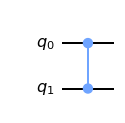

In [20]:
oracle.draw(output='mpl')


In [56]:
from pytket.qasm import circuit_from_qasm, circuit_to_qasm_str
import tempfile, os

fd, path = tempfile.mkstemp(".qasm")
os.write(fd, """OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0], q[1];
cz q[1], q[0];
measure q -> c;
""".encode())
os.close(fd)
circ = circuit_from_qasm(path)
os.remove(path)

print(circuit_to_qasm_str(circ))


OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
cz q[1],q[0];
measure q[0] -> c[0];
measure q[1] -> c[1];



In [57]:
render_circuit_jupyter(circ)

In [67]:
from pytket import Circuit, OpType
from sympy import Symbol
a = Symbol("alpha")
b = Symbol("beta")
circ = Circuit(2)
circ.Rx(a, 0)
circ.Rx(-2*a, 1)
circ.CX(0, 1)
circ.add_gate(OpType.YYPhase, b, [0, 1])
print(circ.get_commands())

s_map = {a: 0.3, b:1.25}
circ.symbol_substitution(s_map)
print(circ.get_commands())

[Rx(alpha) q[0];, Rx(-2*alpha) q[1];, CX q[0], q[1];, YYPhase(beta) q[0], q[1];]
[Rx(0.3) q[0];, Rx(3.4) q[1];, CX q[0], q[1];, YYPhase(1.25) q[0], q[1];]


In [68]:
render_circuit_jupyter(circ)

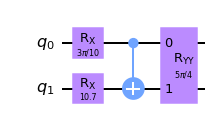

In [69]:
tk_to_qiskit(circ).draw(output='mpl')

In [71]:
from pytket.extensions.qiskit import IBMQBackend, AerStateBackend
dev_b = IBMQBackend("ibmq_athens")
sim_b = AerStateBackend()
print(dev_b.required_predicates)
print(sim_b.required_predicates)

[NoSymbolsPredicate, GateSetPredicate:{ Rz CX U3 noop U2 Measure U1 Barrier X Reset SX }]
[NoClassicalControlPredicate, NoFastFeedforwardPredicate, GateSetPredicate:{ S CnX H Y Sdg Unitary2qBox Ry Rz Mølmer-Sørensen X ZZPhase YYPhase Z T Tdg SX Rx Unitary1qBox U3 U2 U1 CX CY CZ CU1 CU3 CCX SWAP CSWAP noop PhasedX }]


### Compilation

So far, we have already covered enough to be able to design the Circuit s we want to run, submit them to a Backend, and interpret the results in a meaningful way. This is all you need if you want to just try out a quantum computer, run some toy examples and observe some basic results. We actually glossed over a key step in this process by using the Backend.compile_circuit() method. The compilation step maps from the universal computer abstraction presented at Circuit construction to the restricted fragment supported by the target Backend, and knowing what a compiler can do to your program can help reduce the burden of design and improve performance on real devices.

The necessity of compilation maps over from the world of classical computation: it is much easier to design correct programs when working with higher-level constructions that aren’t natively supported, and it shouldn’t require a programmer to be an expert in the exact device architecture to achieve good performance. There are many possible low-level implementations on the device for each high-level program, which vary in the time and resources taken to execute. However, because QPUs are analog devices, the implementation can have a massive impact on the quality of the final outcomes as a result of changing how susceptible the system is to noise. Using a good compiler and choosing the methods appropriately can automatically find a better low-level implementation. Each aspect of the compilation procedure is exposed through pytket to provide users with a way to have full control over what is applied and how.

The primary goals of compilation are two-fold: solving the constraints of the Backend to get from the abstract model to something runnable, and optimising/simplifying the Circuit to make it faster, smaller, and less prone to noise. Every step in compilation can generally be split up into one of these two categories (though even the constraint solving steps could have multiple solutions over which we could optimise for noise).

Each compiler pass inherits from the BasePass class, capturing a method of transforming a Circuit. The main functionality is built into the BasePass.apply() method, which applies the transformation to a Circuit in-place. The Backend.compile_circuit() method is simply an alias for BasePass.apply() from the Backend ‘s recommended pass sequence. This chapter will explore these compiler passes, the different kinds of constraints they are used to solve and optimisations they apply, to help you identify which ones are appropriate for a given task.



### Rebases
One of the simplest constraints to solve for is the GateSetPredicate, since we can just substitute each gate in a Circuit with an equivalent sequence of gates in the target gateset according to some known gate decompositions. In pytket, such passes are referred to as “rebases”. The intention here is to perform this translation naively, leaving the optimisation of gate sequences to other passes. Rebases can be applied to any Circuit and will preserve every structural Predicate, only changing the types of gates used.



In [72]:
from pytket import Circuit
from pytket.passes import RebaseIBM
circ = Circuit(2, 2)
circ.Rx(0.3, 0).Ry(-0.9, 1).CZ(0, 1).S(0).CX(1, 0).measure_all()

RebaseIBM().apply(circ)

print(circ.get_commands())


[U3(0.3, 1.5, 0.5) q[0];, U3(3.1, 0, 0) q[1];, U3(0.5, 0, 1) q[1];, CX q[0], q[1];, U1(0.5) q[0];, U3(0.5, 0, 1) q[1];, CX q[1], q[0];, Measure q[0] --> c[0];, Measure q[1] --> c[1];]


In [77]:
from pytket import Circuit, OpType
from pytket.predicates import GateSetPredicate, NoMidMeasurePredicate
circ = Circuit(2, 2)
circ.Rx(0.2, 0).CX(0, 1).Rz(-0.7, 1).measure_all()

gateset = GateSetPredicate({OpType.Rx, OpType.CX, OpType.Rz, OpType.Measure})
midmeasure = NoMidMeasurePredicate()

print(gateset.verify(circ))
print(midmeasure.verify(circ))



True
True


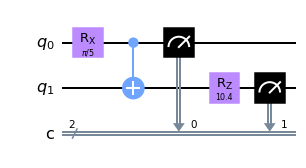

In [78]:
tk_to_qiskit(circ).draw(output='mpl')

In [74]:
circ.S(0)

print(gateset.verify(circ))
print(midmeasure.verify(circ))


False
False


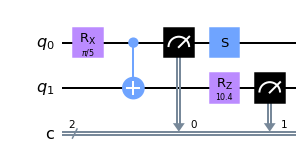

In [76]:
tk_to_qiskit(circ).draw(output='mpl')

frqi - qc1 circuit - max intensity for all the pixels

In [80]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi

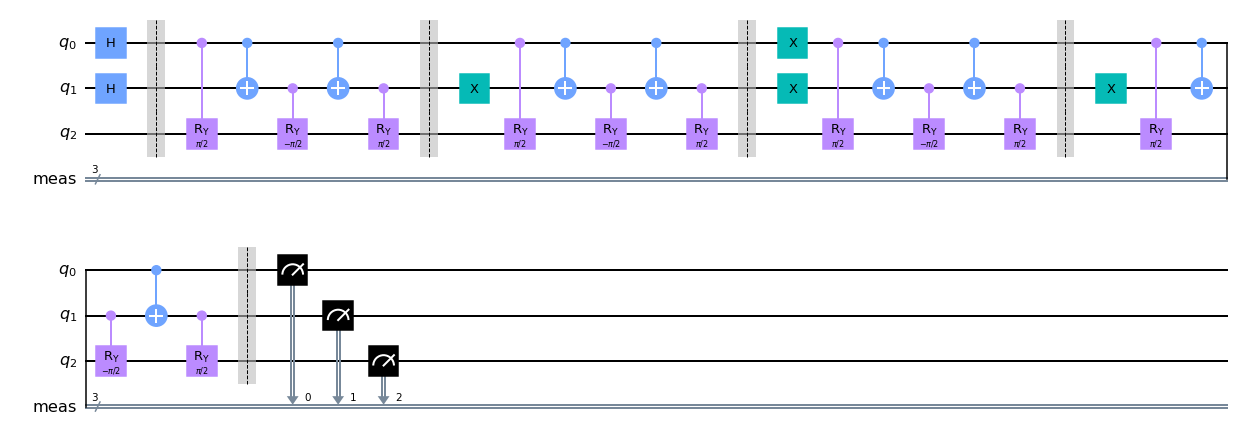

In [83]:
theta = pi/2  # all pixels white
qc1 = QuantumCircuit(3)

qc1.h(0)
qc1.h(1)

qc1.barrier()
#Pixel 1

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.barrier()
#Pixel 2

qc1.x(1)

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.barrier()

qc1.x(1)
qc1.x(0)
qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)


qc1.barrier()

qc1.x(1)

qc1.cry(theta,0,2)
qc1.cx(0,1)
qc1.cry(-theta,1,2)
qc1.cx(0,1)
qc1.cry(theta,1,2)

qc1.measure_all()

qc1.draw(output='mpl')

In [165]:
print("Depth : ", qc1.depth())
print("Operations: ", qc1.count_ops())


Depth :  23
Operations:  OrderedDict([('cry', 12), ('cx', 8), ('barrier', 5), ('x', 4), ('measure', 3), ('h', 2)])


In [202]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc1)
#new_circ.draw()
print("Depth : ", new_circ.depth())
print("Operations: ", new_circ.count_ops())

Depth :  50
Operations:  OrderedDict([('cx', 32), ('u3', 30), ('barrier', 5), ('measure', 3)])


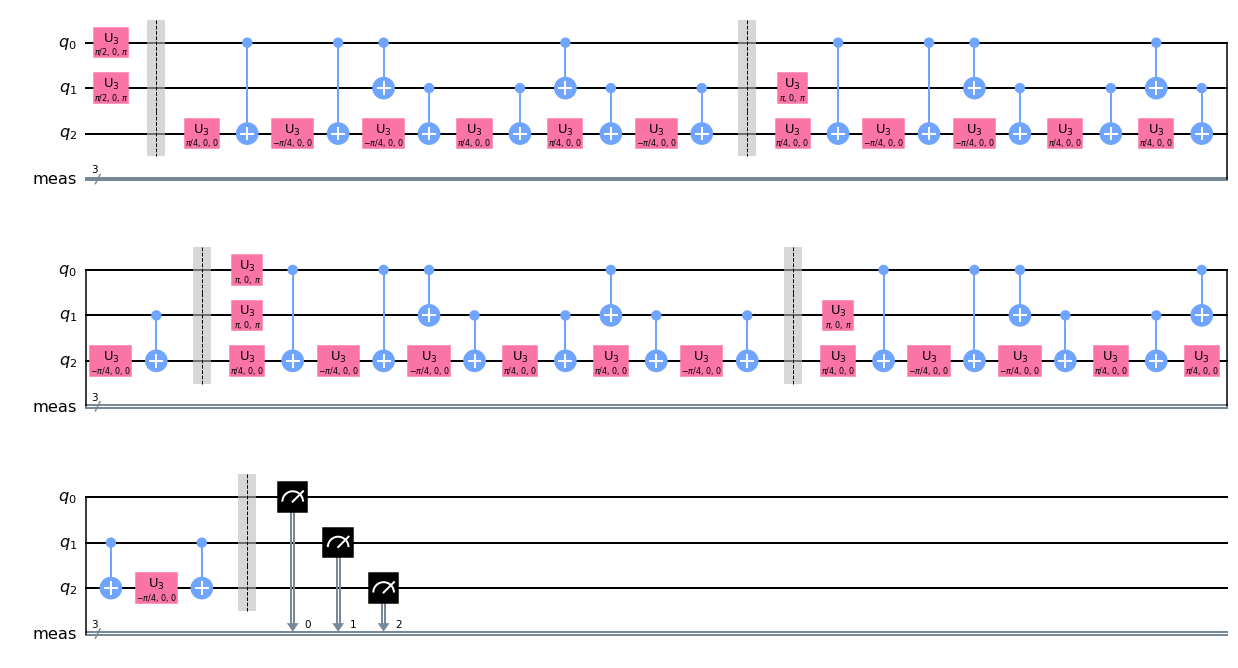

In [199]:
new_circ.draw(output="mpl")

In [204]:
from qiskit.test.mock import FakeAthens
fake_athens = FakeAthens()
# The device coupling map is needed for transpiling to correct
# CNOT gates before simulation
coupling_map = fake_athens.configuration().coupling_map
optimized_3 = transpile(qc1, backend=fake_athens, seed_transpiler=11, optimization_level=3)
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

gates =  OrderedDict([('rz', 74), ('sx', 66), ('cx', 55), ('barrier', 5), ('x', 3), ('measure', 3)])
depth =  158


In [203]:
circ1=qiskit_to_tk(qc1)
#b = AerBackend()
b = IBMQBackend("ibmq_athens")
test = circ1.copy()
RebaseIBM().apply(test)
b.default_compilation_pass(2).apply(test)
assert b.valid_circuit(test)
print("Optimisation level", 2)
print("Depth", test.depth())
print("Gates", test.n_gates)
print("CXs", test.n_gates_of_type(OpType.CX))
print("U3s", test.n_gates_of_type(OpType.U3))
#print(test.get_commands())

Optimisation level 2
Depth 135
Gates 176
CXs 62
U3s 0


In [205]:
from pytket import Circuit, OpType
from pytket.passes import RebaseCustom

multiq_gates = {OpType.CX}
singleq_gates = {OpType.Rz, OpType.X, OpType.SX}
#cx_in_cy = Circuit(2)
#cx_in_cy.Rz(0.5, 1).CY(0, 1).Rz(-0.5, 1)
#def tk1_to_rzry(a, b, c):
#    circ = Circuit(1)
#    circ.Rz(c + 0.5, 0).Ry(b, 0).Rz(a - 0.5, 0)
#    return circ

custom = RebaseCustom(multiq_gates, singleq_gates)

circ = Circuit(3)
circ.X(0).CX(0, 1).Ry(0.2, 1)
circ.add_gate(OpType.ZZPhase, -0.83, [2, 1]).Rx(0.6, 2)

custom.apply(circ)

print(circ.get_commands())

TypeError: RebaseCustom(): incompatible function arguments. The following argument types are supported:
    1. (multiqs: Set[pytket._tket.circuit.OpType], cx_replacement: pytket._tket.circuit.Circuit, singleqs: Set[pytket._tket.circuit.OpType], tk1_replacement: Callable[[Expression, Expression, Expression], pytket._tket.circuit.Circuit]) -> pytket._tket.passes.BasePass

Invoked with: {<OpType.CX: 37>}, {<OpType.Rz: 32>, <OpType.SX: 27>, <OpType.X: 19>}

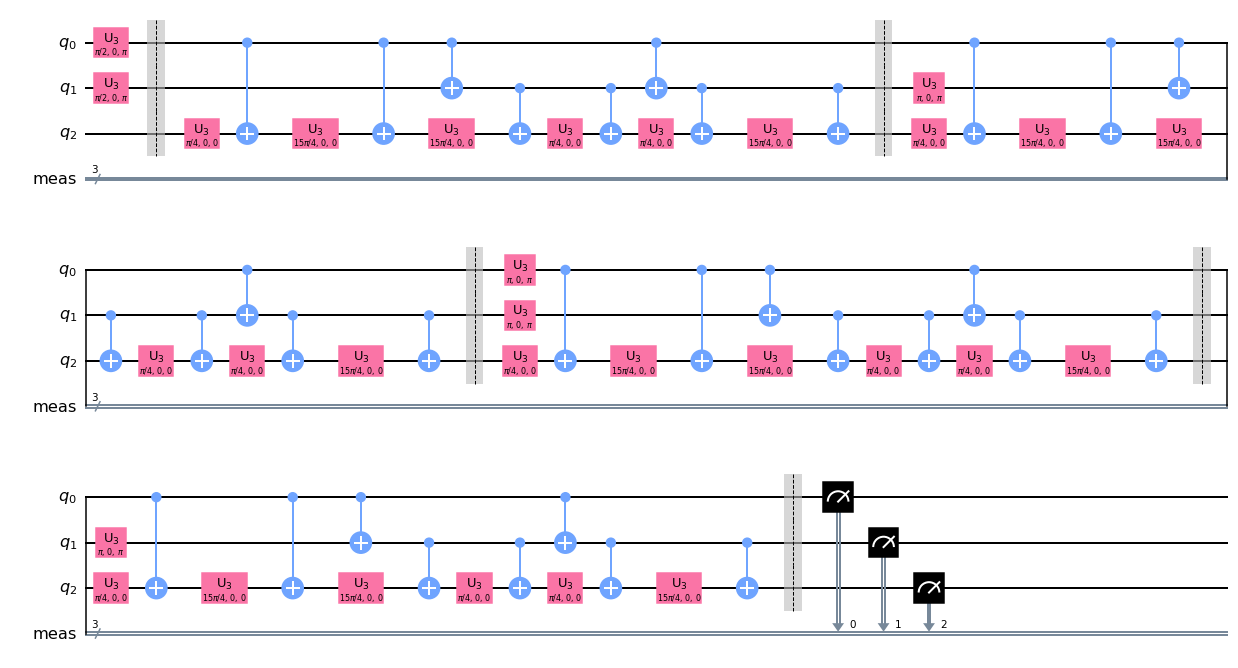

In [198]:
tk_to_qiskit(test).draw(output='mpl')

{'100': 1033, '110': 1036, '101': 1029, '111': 998}


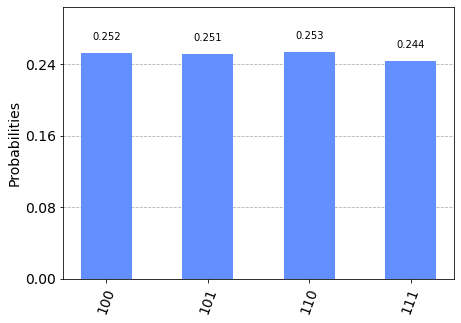

In [104]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc1 = transpile(qc1, qasm_sim)
qobj = assemble(t_qc1, shots=4096)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc1)
print(counts)
plot_histogram(counts)


showing tket added value on top of qiskit: https://github.com/CQCL/pytket/blob/master/examples/qiskit_integration.ipynb

In [84]:
from qiskit.opflow.primitive_ops import PauliSumOp

In [85]:
H2_op = PauliSumOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)


In [86]:
from qiskit.algorithms import NumPyEigensolver


In [87]:
es = NumPyEigensolver(k=1)
exact_result = es.compute_eigenvalues(H2_op).eigenvalues[0].real
print("Exact result:", exact_result)


Exact result: -1.857275030202379


In [88]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2

In [89]:
def vqe_solve(op, maxiter, quantum_instance):
    optimizer = SPSA(maxiter=maxiter)
    ansatz = EfficientSU2(op.num_qubits, entanglement="linear")
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance)
    return vqe.compute_minimum_eigenvalue(op).eigenvalue


In [90]:
from pytket.extensions.qiskit import IBMQEmulatorBackend
from qiskit import IBMQ


In [91]:
IBMQ.load_account()
b_emu = IBMQEmulatorBackend("ibmq_belem", hub="ibm-q", group="open", project="main")


ibmqfactory.load_account:WARNING:2021-05-31 12:08:57,128: Credentials are already in use. The existing account in the session will be replaced.


In [92]:
from pytket.extensions.qiskit.tket_backend import TketBackend
from qiskit.utils import QuantumInstance


In [93]:
qis_backend = TketBackend(b_emu)
qi = QuantumInstance(qis_backend, shots=8192, wait=0.1)


In [137]:
print("VQE result:", vqe_solve(H2_op, 50, qi))


VQE result: -1.7777940979662037


In [95]:
from pytket.passes import FullPeepholeOptimise
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

In [138]:
qis_backend2 = TketBackend(b_emu, FullPeepholeOptimise())
qi2 = QuantumInstance(
    qis_backend2,
    pass_manager=PassManager(Unroller(["cx", "h", "rx", "ry", "rz"])),
    shots=8192,
    wait=0.1,
)

In [139]:
print("VQE result (with optimisation):", vqe_solve(H2_op, 50, qi2))


VQE result (with optimisation): -1.765108142378061
